In [179]:
#Initialization

import importlib

from platform import python_version
import tensorflow as tf
import librosa as lb
import audiomentations as augs
import functools
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import defaultdict
import soundfile as sf
import random
from pathlib import Path
import os
import tensorflow_hub as hub
import datetime
import tensorflow_docs as tfdocs
import tensorflow_docs.plots


from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import data_preprocessing as dpp
importlib.reload(dpp)




import warnings
warnings.filterwarnings("ignore") #ignore warnings

# print system information
print('Python Version           : ', python_version())
print('TensorFlow Version       : ', tf.__version__)
print('Librosa Version          : ', lb.__version__)
print('Audiomentations Version  : ', augs.__version__)

Python Version           :  3.10.12
TensorFlow Version       :  2.17.0
Librosa Version          :  0.10.2.post1
Audiomentations Version  :  0.37.0


# Train New Model to Handle Low Quality

> Author: Regina Arissaputri (223740481)

> Date: 24th November 2024 

In this report, we train the model to take and classify low quality data

As was mentioned in the previous report, the model is not able to classify downsampled data, thus we can infer that the model sees the low quality data as a completely new data. Thus we need to train the model to take low quality data instead, as the goal of this section is to get the minimum data size while also getting decent accuracy.

## 4000Hz Downsampled Data

In [136]:
# update SC
SC = dpp.update_global_config({'AUDIO_DATA_DIRECTORY4000': "C:/Users/regin/Documents/SIT374/new_data4000", #new dataset location.,
                             'AUDIO_SAMPLE_RATE': 4000,
                             'AUDIO_NFFT': 256,
                             'AUDIO_STRIDE': 50,
                             'AUDIO_MELS': 128,
                             'AUDIO_FMAX': 2000,
                             'AUDIO_TOP_DB': 60,
                            })

### File Checking

First, we need to check the files of the audio data that we have. 

In [137]:
# labels, class_names = dpp.species_list(config.SC['AUDIO_DATA_DIRECTORY'])

print(f" labels: {dpp.labels}")
print(f"class_names: {dpp.class_names}")
print(f"Number of classes: {len(dpp.class_names)}")

 labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

### Preprocessing
Here we preprocess the data into mel spectrograph images.

But before that, we make a tensorflow dataset that contains the class names and file paths.

In [138]:
ds4000 = dpp.create_datasets(SC['AUDIO_DATA_DIRECTORY4000'], dpp.class_names, samples = 1000)

print(f"Number of samples: {len(ds4000)}")
print(f"print labels from dataset with 4000Hz {ds4000}")

Number of samples: 7514
print labels from test_ds <_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(118,), dtype=tf.float32, name=None))>


In [139]:
# Apply the split
train_ds4000, val_ds4000, test_ds4000 = dpp.split_dataset(ds4000, 0.7, 0.2, 0.1)

print(f"Training Samples: {len(train_ds4000)}")
print(f"Validation Samples: {len(val_ds4000)}")
print(f"Testing Samples: {len(test_ds4000)}")

Training Samples: 5259
Validation Samples: 1502
Testing Samples: 753


The code below will convert the audio data to mel spectrograph and ensure that the data is in the correct format to input into the model. 

#### Data Generation Pipeline

In [140]:

# Get the length of the training dataset
train_ds_len = len(train_ds4000)
parallel_calls = tf.data.AUTOTUNE
cache_output_types = (tf.string,tf.float32)
procs_output_types = (tf.float32,tf.float32)

# Create the training dataset pipeline
train4000 = (train_ds4000
            .shuffle(train_ds_len)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
            # .map(functools.partial(python_function_wrapper, python_audio_augmentations, procs_output_types), num_parallel_calls=parallel_calls)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
            .batch(16)
            .prefetch(parallel_calls)
            .repeat(count=1)
)

# Create the validation dataset pipeline
val4000 = (val_ds4000
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
            .batch(16)
            .prefetch(parallel_calls)
            .repeat(count=1)
)

# Create the test dataset pipeline
test4000 = (test_ds4000
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
            .batch(16)
            .prefetch(parallel_calls)
            .repeat(count=1)
)

Let's check the pipeline for now, the blank area is due to padding, because we want 5 seconds audio.

 sample info: (16, 260, 260, 3), 
 label info: (16, 118) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


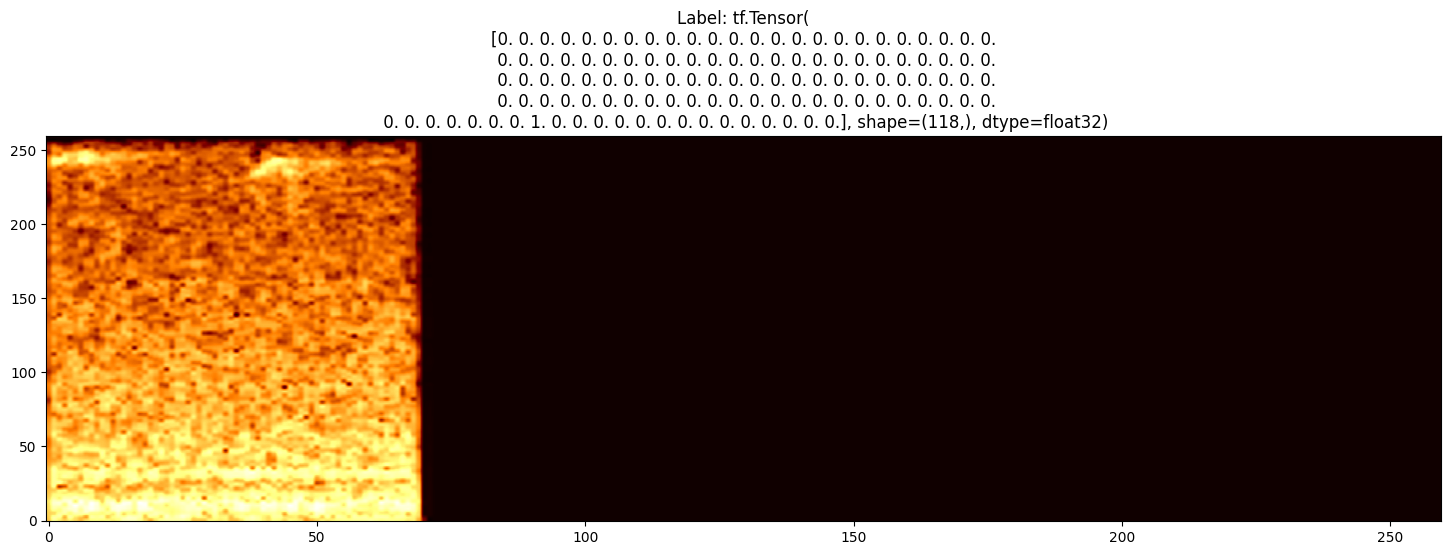

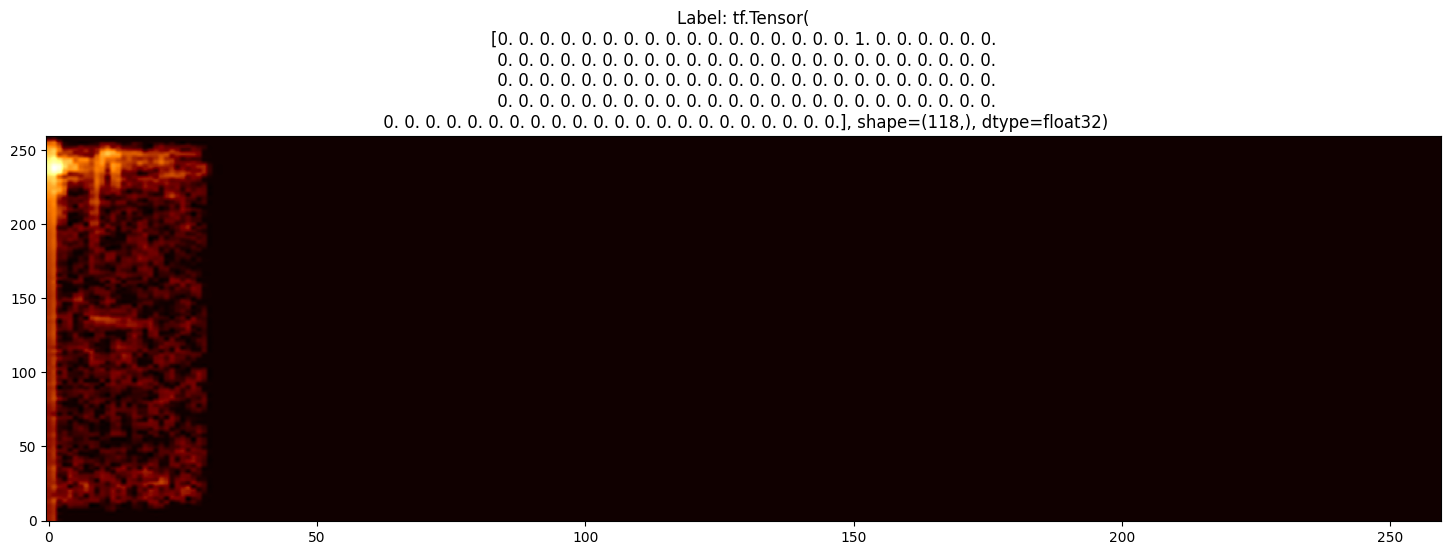

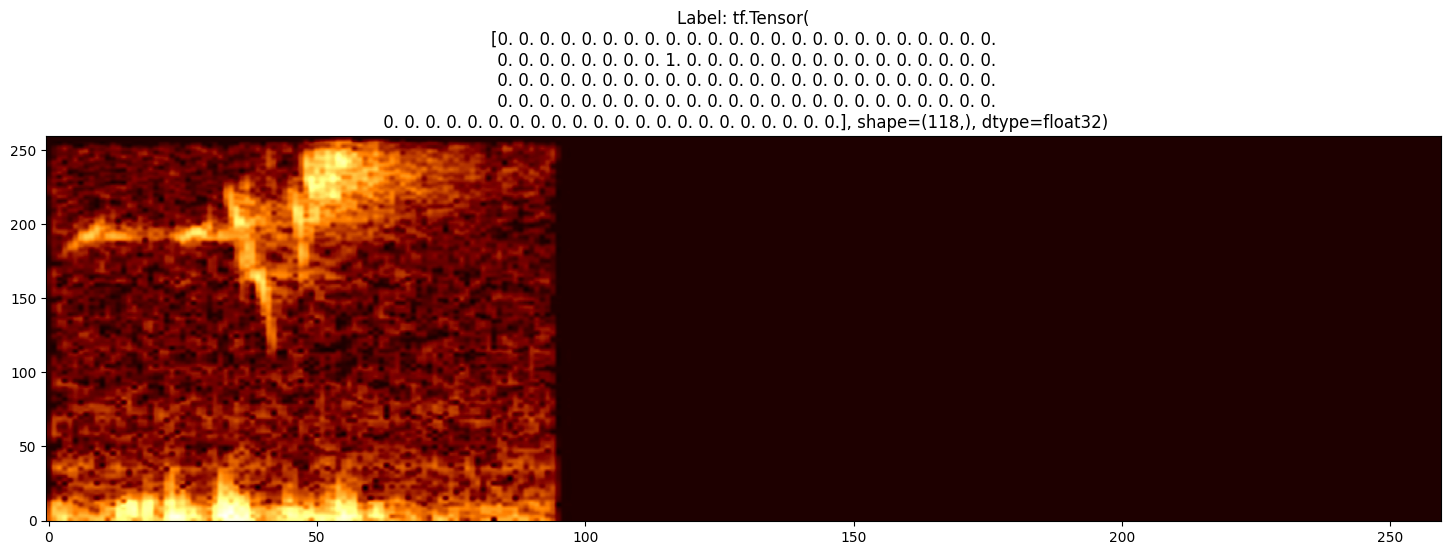

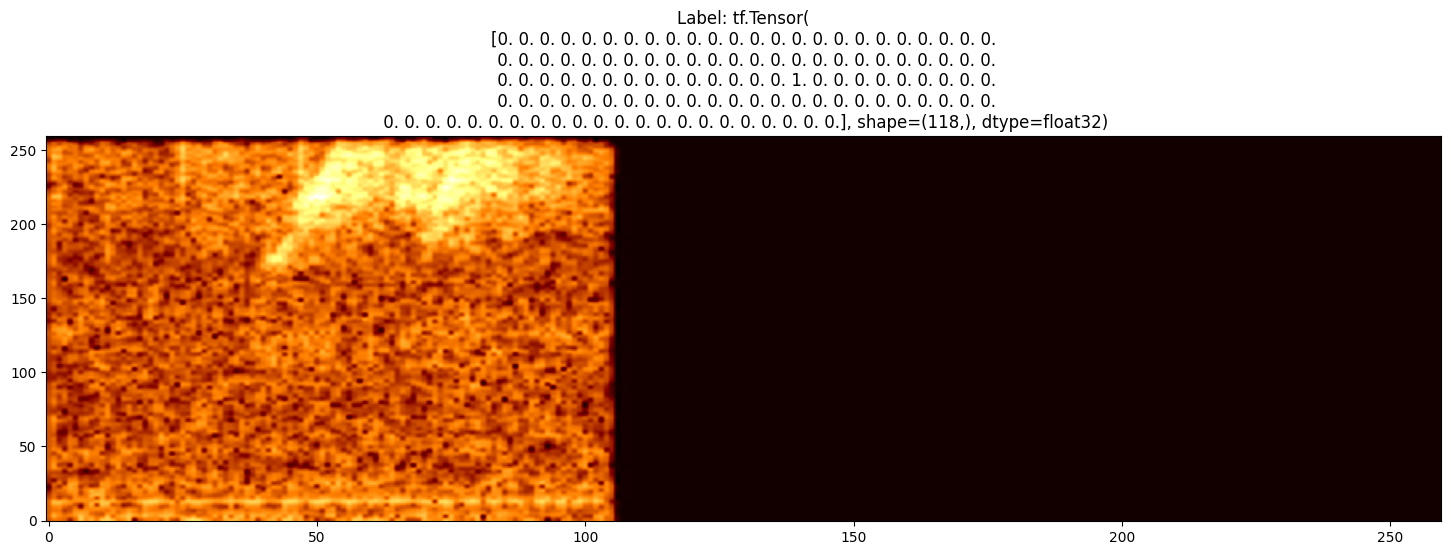

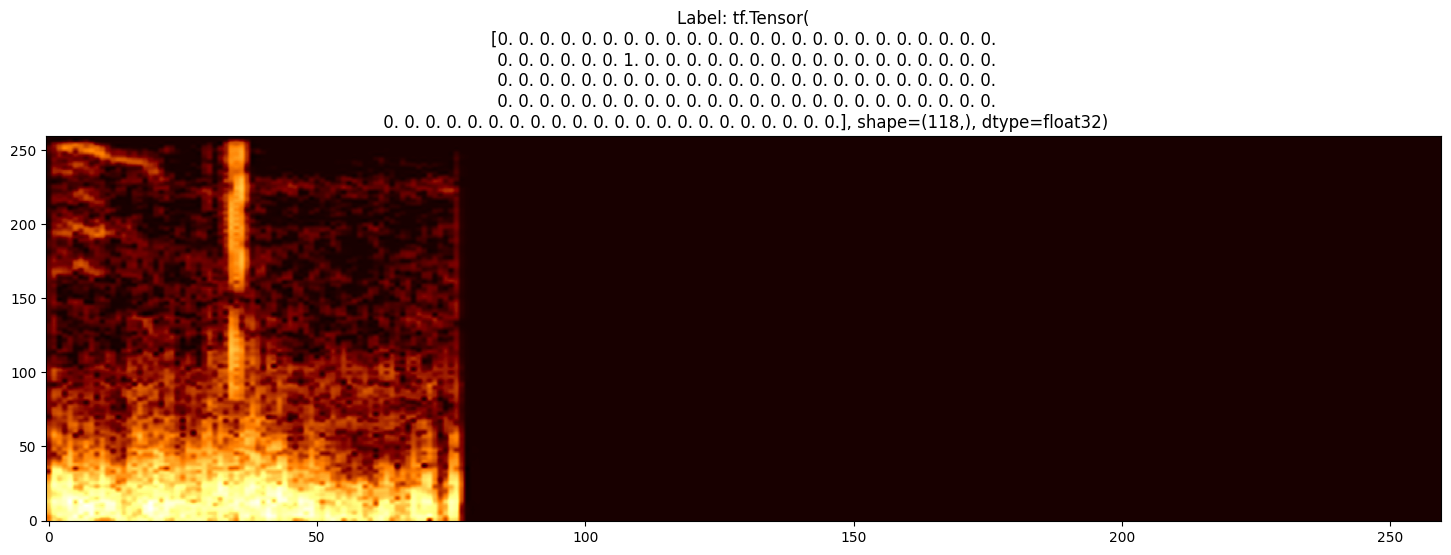

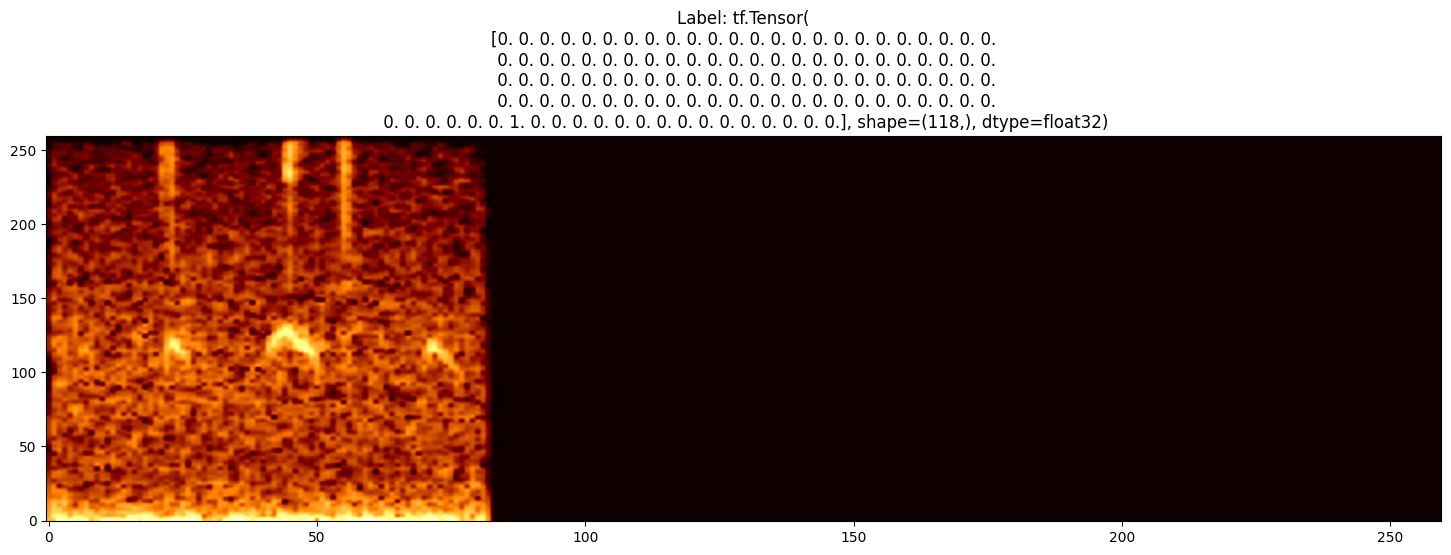

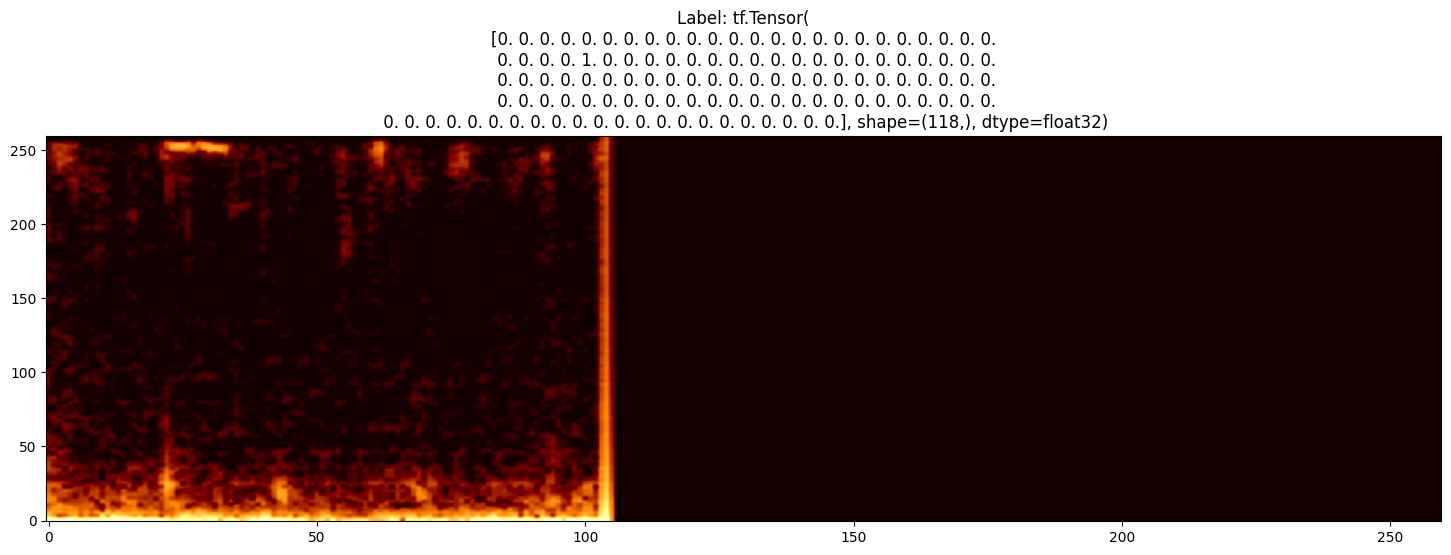

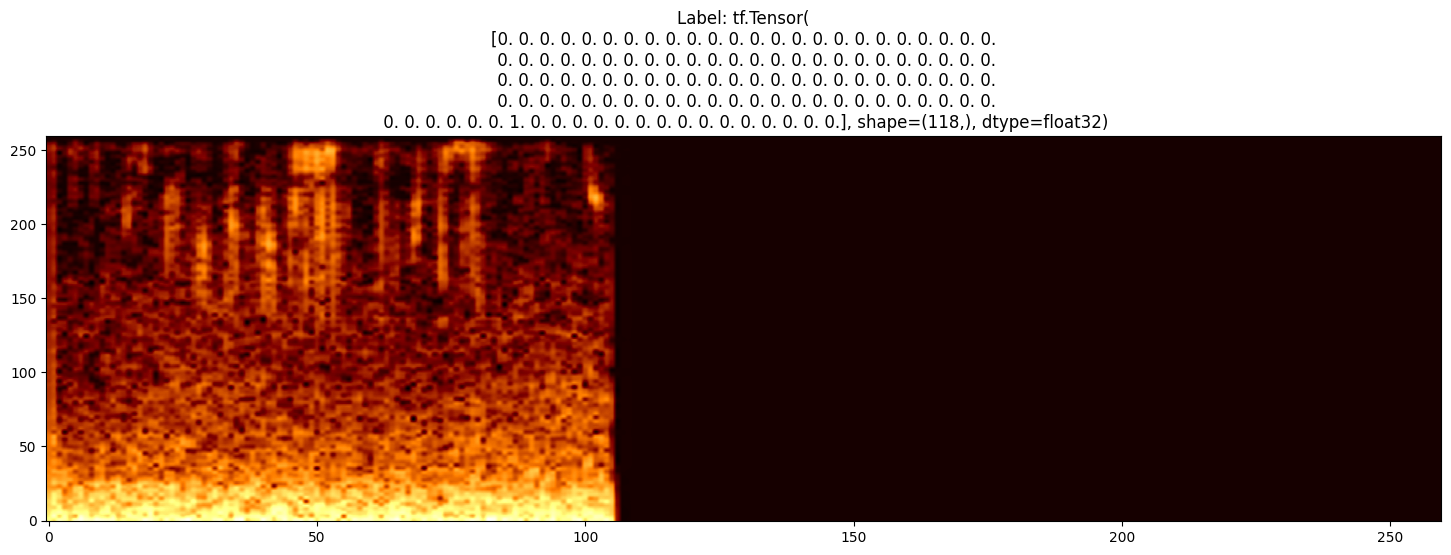

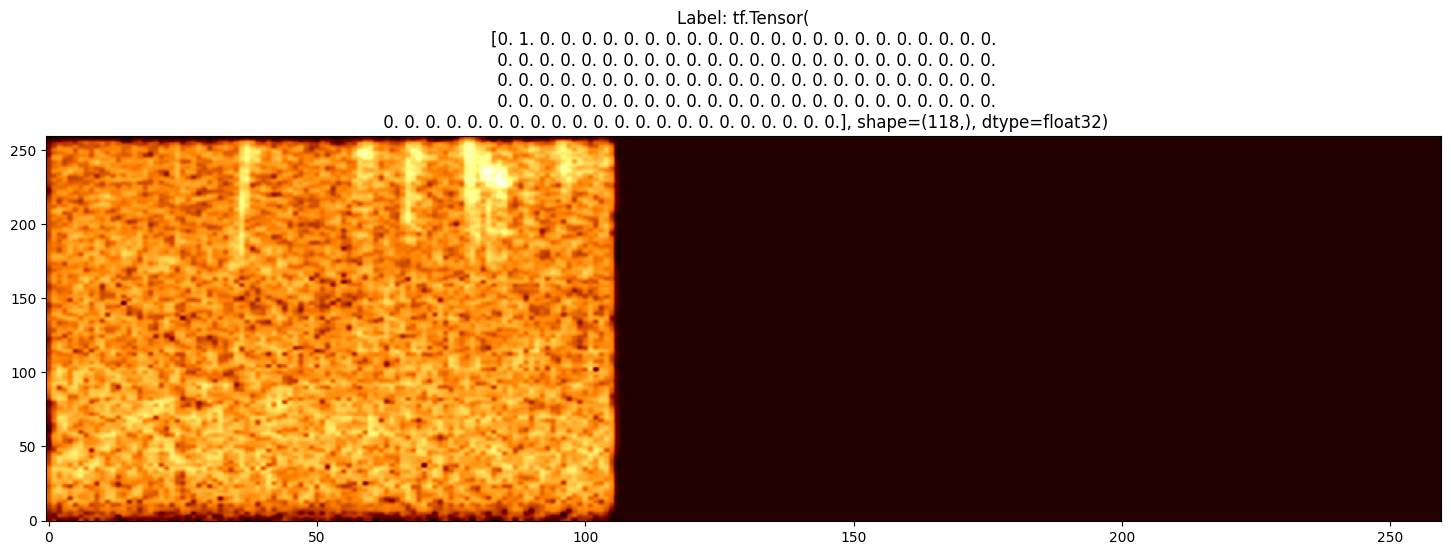

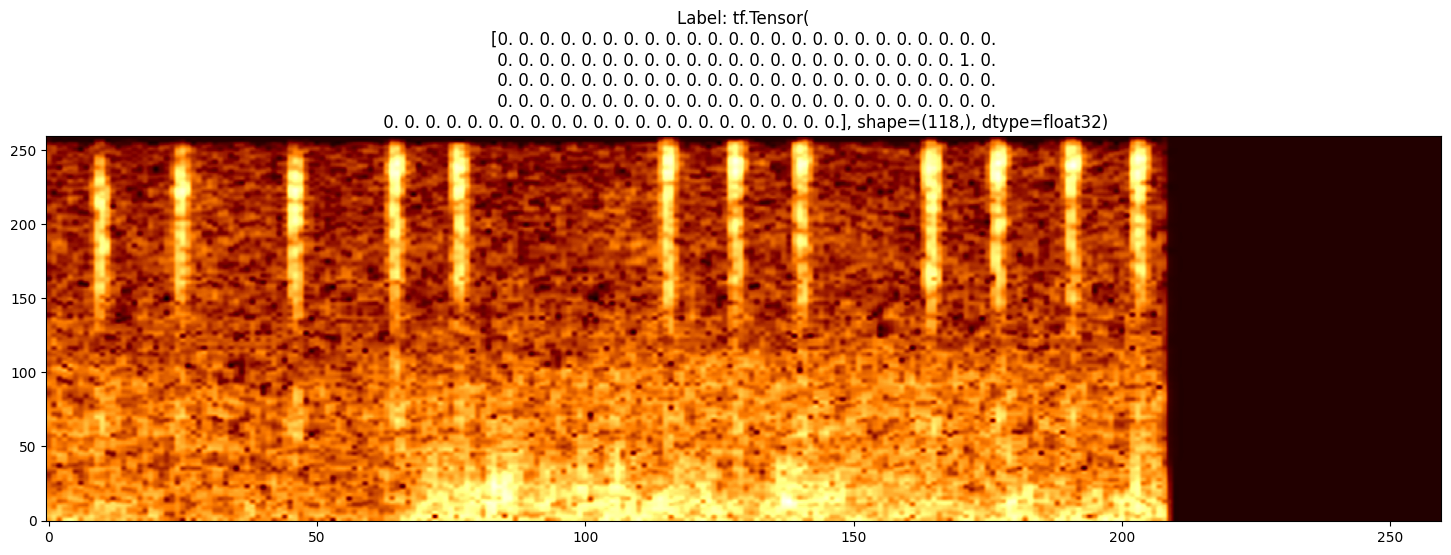

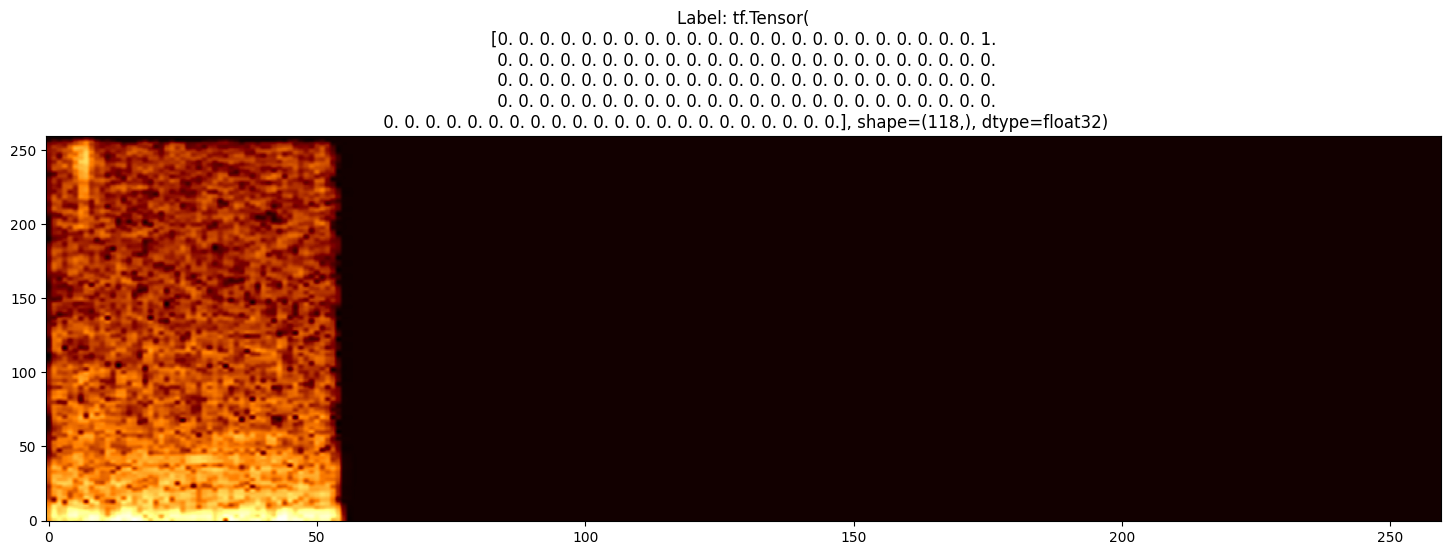

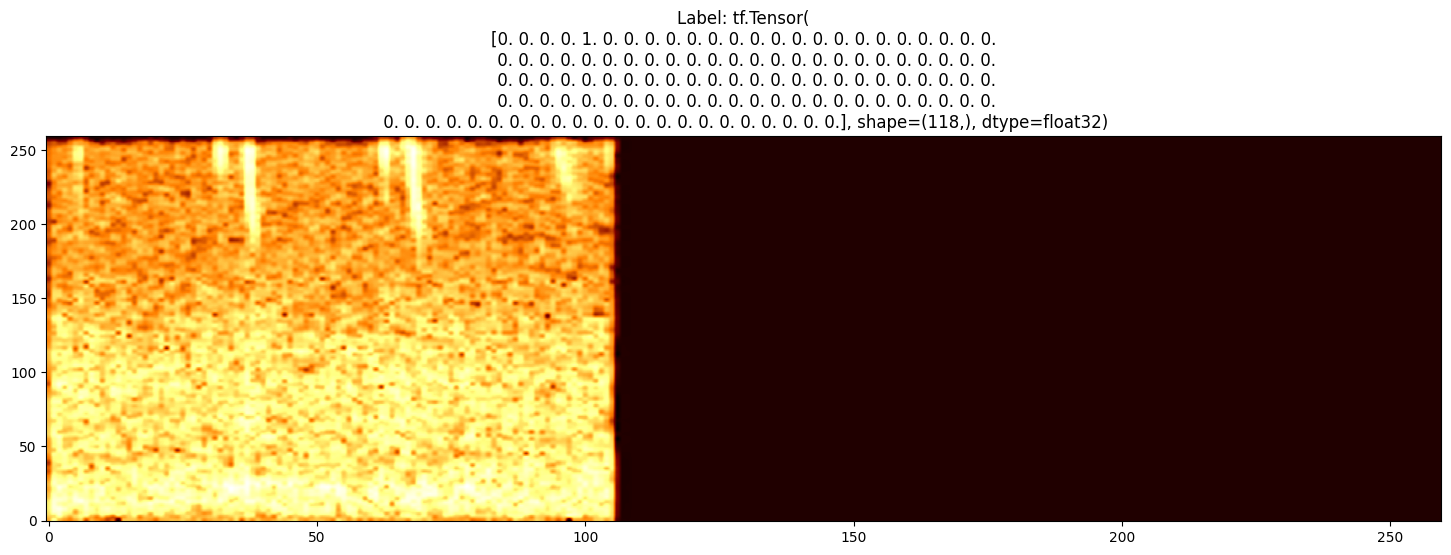

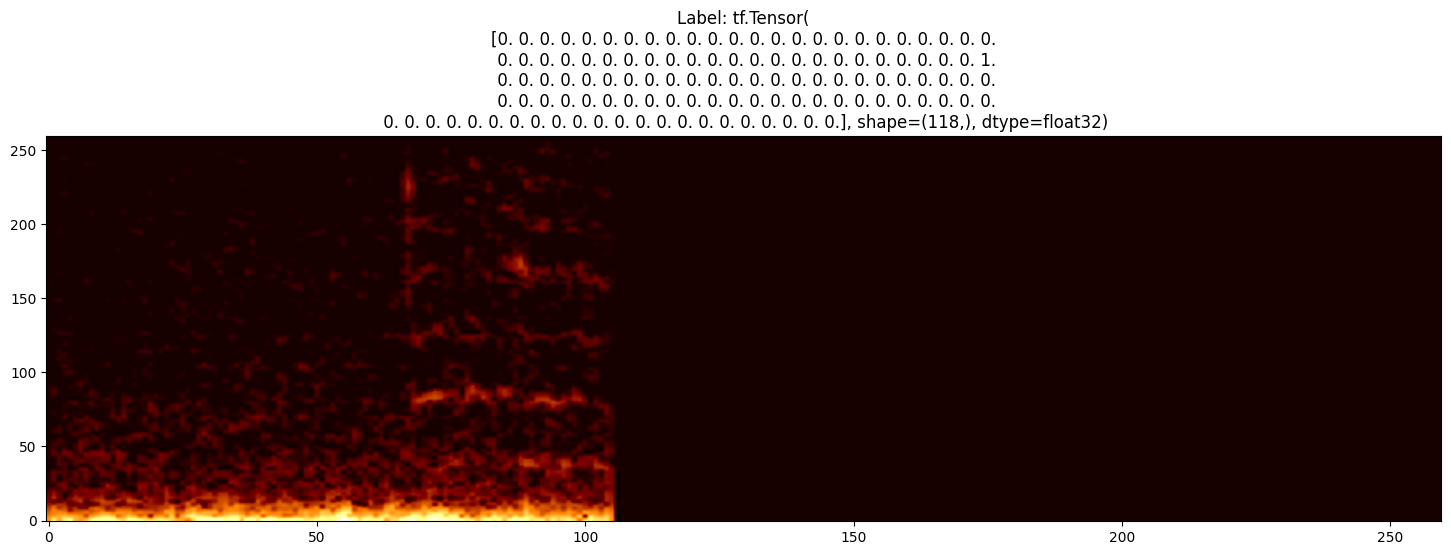

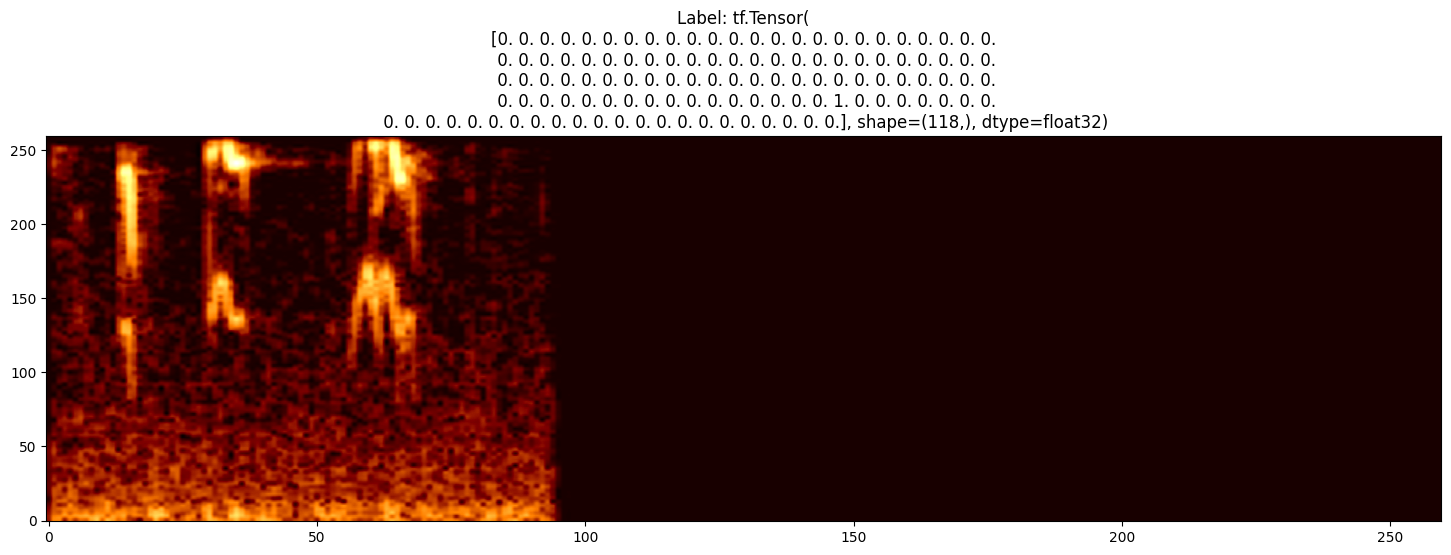

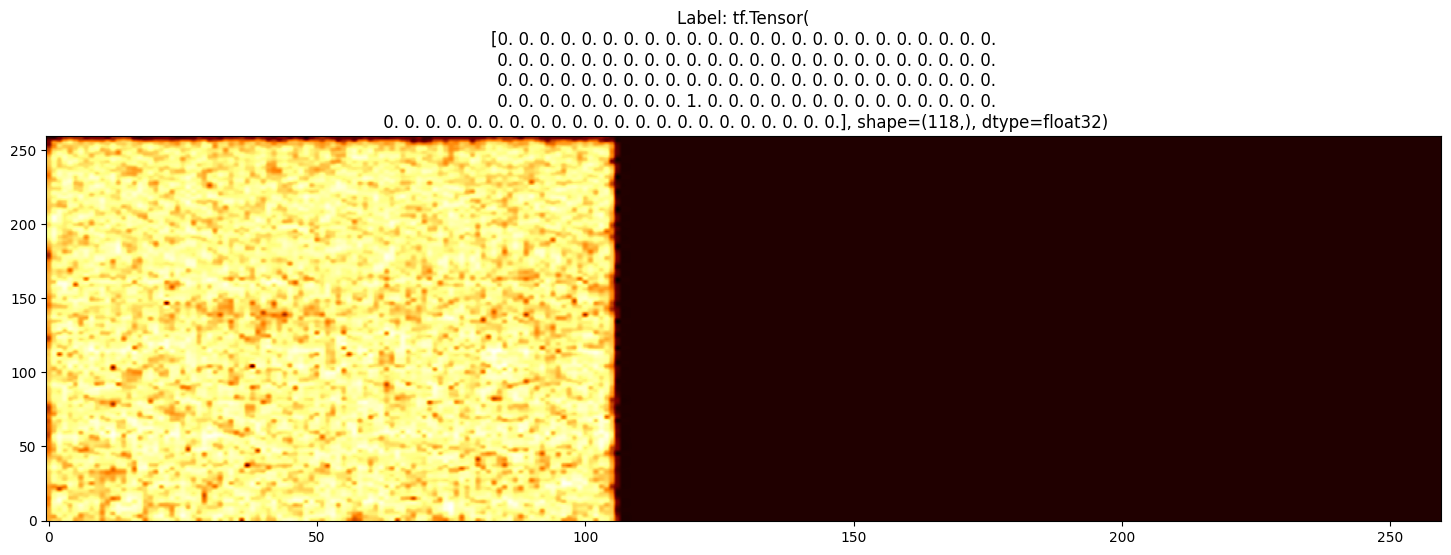

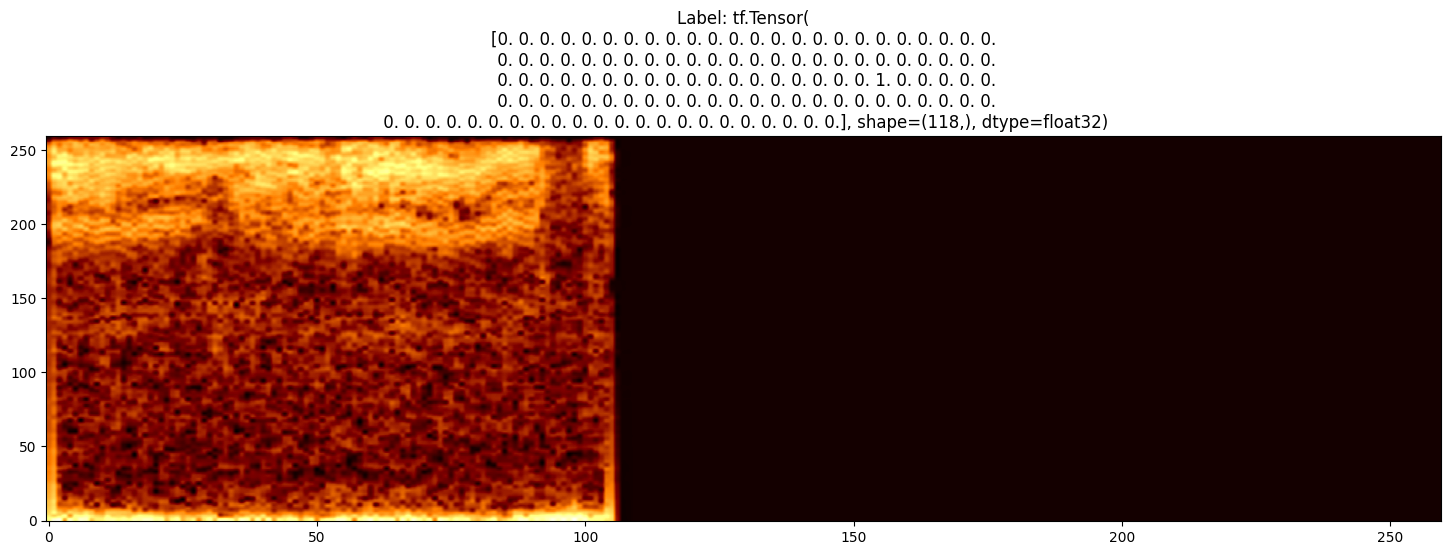

In [141]:
for melspectrogram,label in train4000.take(1):
    print(f' sample info: {melspectrogram.shape}, \n label info: {label.shape} \n {label}')
    for example in range(melspectrogram.shape[0]):
        plt.figure(figsize=(18,5))
        plt.imshow(melspectrogram[example,:,:,0].numpy().T, cmap='afmhot', origin='lower', aspect='auto')
        plt.title('Label: ' + str(label[example,:]))
        plt.show()

Make directory to save the model on local device

In [142]:
# only run the code below if want to save the model
if not os.path.exists('C:/Users/regin/Documents/SIT374/models/new_models/4000Hz'):
    os.mkdir('C:/Users/regin/Documents/SIT374/models/new_models/4000Hz') 

## Building the Model
This model leverages pre-trained model weights for the EfficientNetV2 feature model which generates a vector representation of 1000 floats for each input image. The output from the EfficientNetV2 model is then fed into 2 fully connected layers to perform the classification function.

Note: new link to model: https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2

In [143]:
SCM = {
    'MODEL_INPUT_IMAGE_WIDTH': 260,
    'MODEL_INPUT_IMAGE_HEIGHT': 260,
    'MODEL_INPUT_IMAGE_CHANNELS': 3,
    'MAX_EPOCHS': 30
}

In [184]:
# Custom layer to wrap hub.KerasLayer
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, hub_url, trainable=True):
        super(HubLayer, self).__init__()
        self.hub_layer = hub.KerasLayer(hub_url, trainable=trainable)

    def call(self, inputs):
        return self.hub_layer(inputs)

def build_model(trainable):
    # Build a classification model using a pre-trained EfficientNetV2
    model = tf.keras.Sequential(
        [
            # Input layer with specified image dimensions
            tf.keras.layers.InputLayer(input_shape=(SCM['MODEL_INPUT_IMAGE_HEIGHT'], 
                                                    SCM['MODEL_INPUT_IMAGE_WIDTH'], 
                                                    SCM['MODEL_INPUT_IMAGE_CHANNELS'])),

            # Use the EfficientNetV2 model as a feature generator (needs 260x260x3 images)
            HubLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", trainable),

            # Add the classification layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),

            # Fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(dpp.class_names) * 8,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Another fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(dpp.class_names) * 4,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Add dropout to reduce overfitting
            tf.keras.layers.Dropout(0.50),

            # Output layer with one node per class, without activation
            tf.keras.layers.Dense(len(dpp.class_names), activation=None),
        ]
    )
    # Set the input shape for the model
    model.build([None, 
                 SCM['MODEL_INPUT_IMAGE_HEIGHT'],
                 SCM['MODEL_INPUT_IMAGE_WIDTH'], 
                 SCM['MODEL_INPUT_IMAGE_CHANNELS']])

    # Display the model summary
    model.summary()

    return model

In [145]:
# allow all the weights to be trained
model4000 = build_model(True)


# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model4000.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.75,
                                                      patience=8, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-7)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=16,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model.keras', 
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# # any changes to the source code will generally require the disk cache to be cleared.
# # So to be safe, the cache is cleared before training the model.  If you are sure
# # the cache is still valid then comment out this code
# # the first few epochs of the model training will be slow as the cache is populated with pipeline samples
# # and will depend on the dataset size and the number of variants included
# cache.clear()

# fit the model to the training set
# this may take 12-24 hours to run to full model convergence depending on your machine
history4000 = model4000.fit(train4000, 
                            validation_data=val4000,
                            callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
                            epochs=SCM['MAX_EPOCHS'])      

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hub_layer_4 (HubLayer)          │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 944)            │     1,209,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 944)            │         3,776 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 472)            │       446,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 472)            │         1,888 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 472)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 118)            │        55,814 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,721,902 (6.57 MB)

 Trainable params: 1,716,510 (6.55 MB)

 Non-trainable params: 5,392 (21.06 KB)

Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 99s 277ms/step - accuracy: 0.1083 - loss: 5.0816 - val_accuracy: 0.2783 - val_loss: 3.2911 - learning_rate: 1.0000e-04
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 99s 300ms/step - accuracy: 0.3095 - loss: 3.3705 - val_accuracy: 0.4887 - val_loss: 2.2232 - learning_rate: 1.0000e-04
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 94s 284ms/step - accuracy: 0.3740 - loss: 2.8794 - val_accuracy: 0.5626 - val_loss: 1.8635 - learning_rate: 1.0000e-04
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 93s 281ms/step - accuracy: 0.4310 - loss: 2.6147 - val_accuracy: 0.5859 - val_loss: 1.7350 - learning_rate: 1.0000e-04
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 89s 268ms/step - accuracy: 0.4809 - loss: 2.2525 - val_accuracy: 0.6525 - val_loss: 1.4290 - learning_rate: 1.0000e-04
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 88s 266ms/step - accuracy: 0.4894 - loss: 2.1912 - val_accuracy: 0.6651 - val_loss: 1.3530 - learning_rate: 1.0000e-04
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 88s 26

In [146]:
# Save the full model for use with tensorflow serving
model4000.export('C:/Users/regin/Documents/SIT374/models/new_models/4000Hz')

INFO:tensorflow:Assets written to: C:/Users/regin/Documents/SIT374/models/new_models/4000Hz\assets


INFO:tensorflow:Assets written to: C:/Users/regin/Documents/SIT374/models/new_models/4000Hz\assets


Saved artifact at 'C:/Users/regin/Documents/SIT374/models/new_models/4000Hz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 118), dtype=tf.float32, name=None)
Captures:
  2797035597040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035596688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035596336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035594928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035594576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035593168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035592816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035592464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035592112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2797035593520: TensorSpec(shape=(), dtype=tf.resource, na

In [180]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({ "4000 Hz": history4000}, metric = "accuracy")
plt.title("Model accuracy")
plt.ylim([0,1])

NameError: name 'history4000' is not defined

## Prediction Using the Model



In [147]:
# Initialize variables to track metrics
true_labels_all4000 = []
predicted_labels_all4000 = []
class_incorrect4000 = defaultdict(int)
class_correct4000 = defaultdict(int)  # Correct predictions per class
class_total4000 = defaultdict(int)  # Total predictions per class


# run predictions
for features, labels in test4000:
    predictions_dict = model4000(features, training=False)
    predictions = model4000.predict(features, verbose=0)

    for batch_idx in range(predictions.shape[0]):
        # Get the true and predicted classes
        true_class = tf.argmax(labels[batch_idx]).numpy()
        predicted_class = int(tf.argmax(predictions[batch_idx]).numpy())

        true_labels_all4000.append(true_class)
        predicted_labels_all4000.append(predicted_class)

        # Update per-class metrics
        class_total4000[true_class] += 1
        if true_class == predicted_class:
            class_correct4000[true_class] += 1
        else:
            class_incorrect4000[true_class] += 1

# Calculate overall accuracy
overall_accuracy4000 = accuracy_score(true_labels_all4000, predicted_labels_all4000)
print(f"Overall Accuracy: {overall_accuracy4000 * 100:.2f}%")

# Print metrics per class
print("\nPrediction Results:")
for idx, class_name in enumerate(dpp.class_names):
    correct = class_correct4000[idx]
    incorrect = class_incorrect4000[idx]
    total = class_total4000[idx]

    print(f"Class: {class_name}")
    print(f"  Total Predictions: {total}")
    print(f"  Correct Predictions: {correct}")
    print(f"  Incorrect Predictions: {incorrect}")
    if total > 0:
        print(f"  Accuracy: {correct / total * 100:.2f}%")
    else:
        print("  No predictions for this class")

# Confusion Matrix
conf_matrix4000 = confusion_matrix(true_labels_all4000, predicted_labels_all4000)



Overall Accuracy: 95.48%

Prediction Results:
Class: Acanthiza chrysorrhoa
  Total Predictions: 3
  Correct Predictions: 2
  Incorrect Predictions: 1
  Accuracy: 66.67%
Class: Acanthiza lineata
  Total Predictions: 1
  Correct Predictions: 1
  Incorrect Predictions: 0
  Accuracy: 100.00%
Class: Acanthiza nana
  Total Predictions: 13
  Correct Predictions: 12
  Incorrect Predictions: 1
  Accuracy: 92.31%
Class: Acanthiza pusilla
  Total Predictions: 24
  Correct Predictions: 23
  Incorrect Predictions: 1
  Accuracy: 95.83%
Class: Acanthiza reguloides
  Total Predictions: 18
  Correct Predictions: 16
  Incorrect Predictions: 2
  Accuracy: 88.89%
Class: Acanthiza uropygialis
  Total Predictions: 11
  Correct Predictions: 11
  Incorrect Predictions: 0
  Accuracy: 100.00%
Class: Acanthorhynchus tenuirostris
  Total Predictions: 10
  Correct Predictions: 8
  Incorrect Predictions: 2
  Accuracy: 80.00%
Class: Accipiter cirrocephalus
  Total Predictions: 10
  Correct Predictions: 9
  Incorrect

We can see that the overall accuracy on a test dataset is 95%, which is considered a high accuracy. Thus training the model on low quality data is possible and does not compromise the accuracy of the model. 

# Combining Datasets
In this section, we are going to combine the downsampled datasets (of 4000 Hz, 8000 Hz, and 16000 Hz) and the original dataset so that can achieve a model that can classify all quality of data. 

Previous analysis shows that animal vocalization range falls between 500 - 2000 Hz, with some subtle patterns on 3000 - 5000 Hz (document written by Nhat Minh Dang: Effect of Frequency Band Removal)

Because we are going to combine all of the downsampled data, we will use system constant of 16000 Hz when converting it to mel spectrograph, as it will still include the important frequency range of 500 - 5000 Hz, which is where most animal vocalization range falls

In [168]:
# update SC
SC = dpp.update_global_config({'AUDIO_DATA_DIRECTORY16000': "C:/Users/regin/Documents/SIT374/new_data16000", #new dataset location.,
                               'AUDIO_DATA_DIRECTORY8000': "C:/Users/regin/Documents/SIT374/new_data8000",
                               'AUDIO_SAMPLE_RATE': 16000,
                               'AUDIO_NFFT': 512,
                               'AUDIO_STRIDE': 50,
                               'AUDIO_MELS': 126,
                               'AUDIO_FMAX': 8000,
                               'AUDIO_TOP_DB': 80,
                            })

In [170]:
ds16000 = dpp.create_datasets(SC['AUDIO_DATA_DIRECTORY16000'], dpp.class_names, samples = 1000)
ds8000 = dpp.create_datasets(SC['AUDIO_DATA_DIRECTORY8000'], dpp.class_names, samples = 1000)
ds_ori = dpp.create_datasets(SC['AUDIO_DATA_DIRECTORY'], dpp.class_names, samples = 1000)

print(f"Number of samples 4000 Hz: {len(ds16000)}")
print(f"Number of samples 8000 Hz: {len(ds8000)}")
print(f"Number of samples 16000 Hz: {len(ds16000)}")
print(f"Number of samples original Hz: {len(ds_ori)}")


Number of samples 4000 Hz: 7514
Number of samples 8000 Hz: 7514
Number of samples 16000 Hz: 7514
Number of samples original Hz: 7514


In [171]:
#Combine the dataset with concat
ds_combined = ds4000.concatenate(ds16000).concatenate(ds8000).concatenate(ds_ori)

#print number of samples
print(f"Number of samples combined: {len(ds_combined)}")
print(f"print labels from dataset {ds_combined}")

Number of samples combined: 30056
print labels from dataset <_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(118,), dtype=tf.float32, name=None))>


In [172]:
# Apply the split
train_ds_combined, val_ds_combined, test_ds_combined = dpp.split_dataset(ds_combined, 0.7, 0.2, 0.1)

print(f"Training Samples: {len(train_ds_combined)}")
print(f"Validation Samples: {len(val_ds_combined)}")
print(f"Testing Samples: {len(test_ds_combined)}")

Training Samples: 21039
Validation Samples: 6011
Testing Samples: 3006


In [182]:

# Get the length of the training dataset
train_len_combined = len(train_ds_combined)
parallel_calls = tf.data.AUTOTUNE
cache_output_types = (tf.string,tf.float32)
procs_output_types = (tf.float32,tf.float32)

# Create the training dataset pipeline
train_combined = (train_ds_combined
            .shuffle(train_len_combined)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
            # .map(functools.partial(python_function_wrapper, python_audio_augmentations, procs_output_types), num_parallel_calls=parallel_calls)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
            .batch(16)
            .prefetch(parallel_calls)
            .repeat(count=1)
)

# Create the validation dataset pipeline
val_combined = (val_ds_combined
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
            .batch(16)
            .prefetch(parallel_calls)
            .repeat(count=1)
)

# Create the test dataset pipeline
test_combined = (test_ds_combined
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
            .map(functools.partial(dpp.python_function_wrapper, dpp.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
            .map(dpp.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
            .batch(16)
            .prefetch(parallel_calls)
            .repeat(count=1)
)

 sample info: (16, 260, 260, 3), 
 label info: (16, 118) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


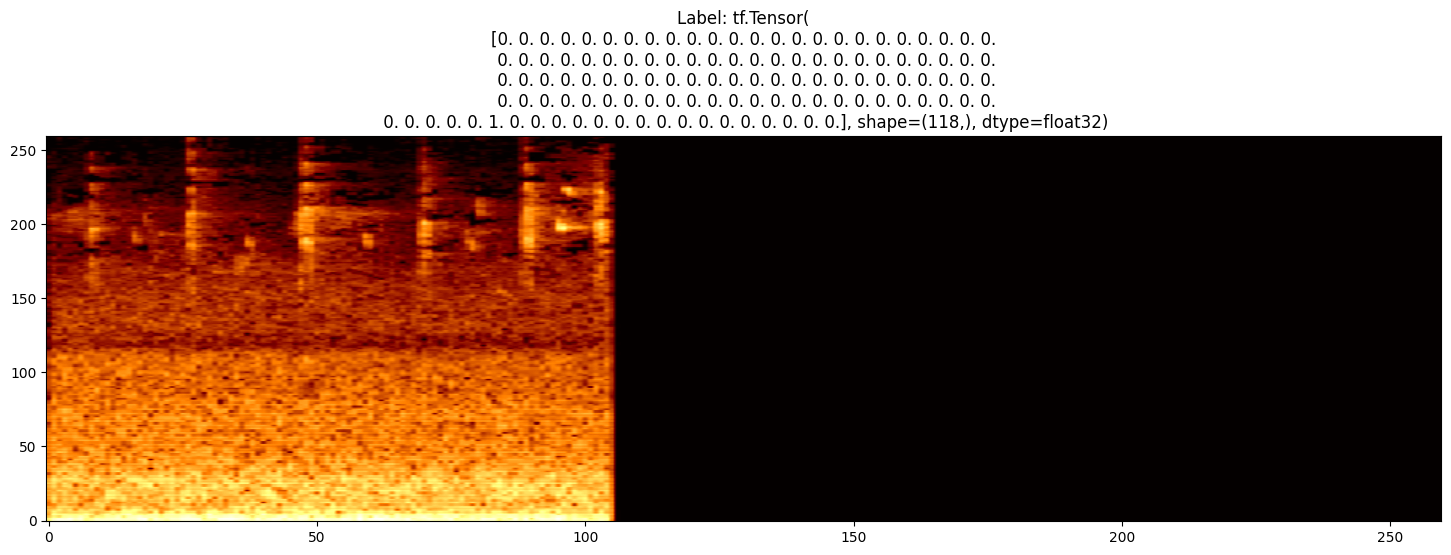

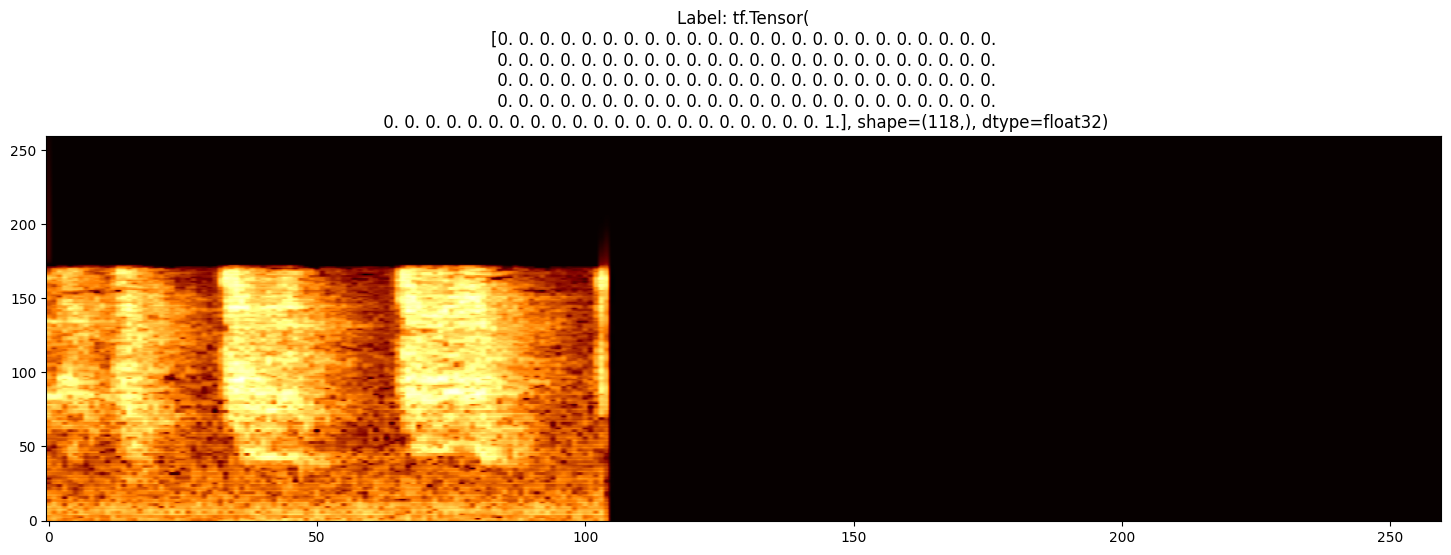

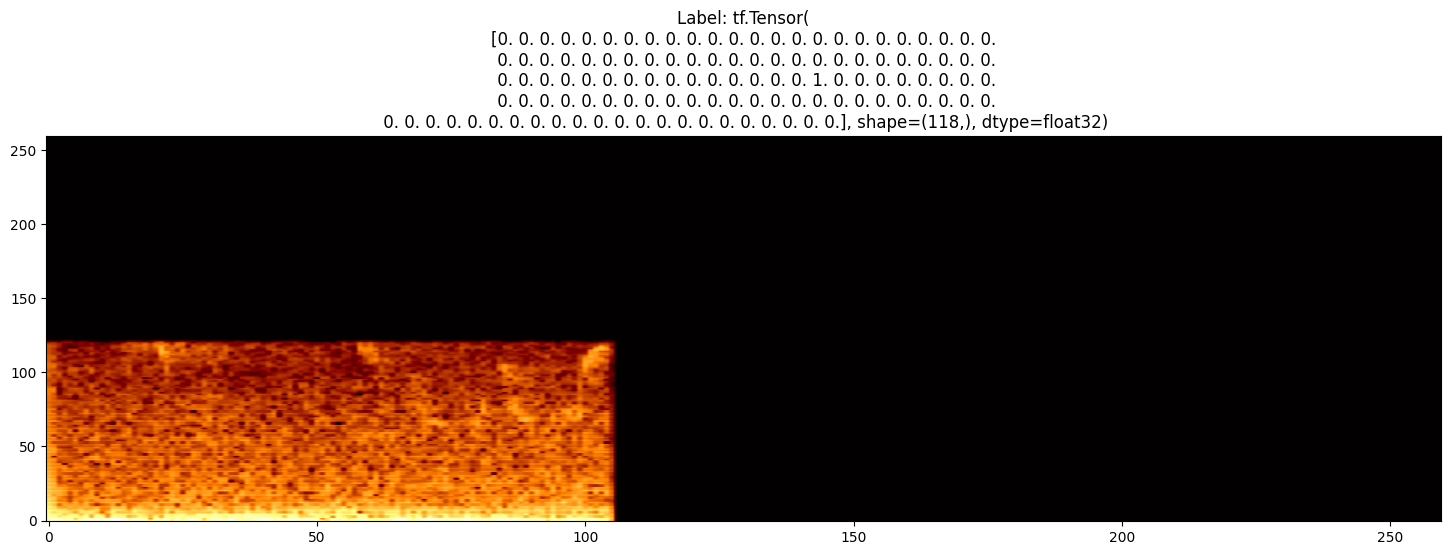

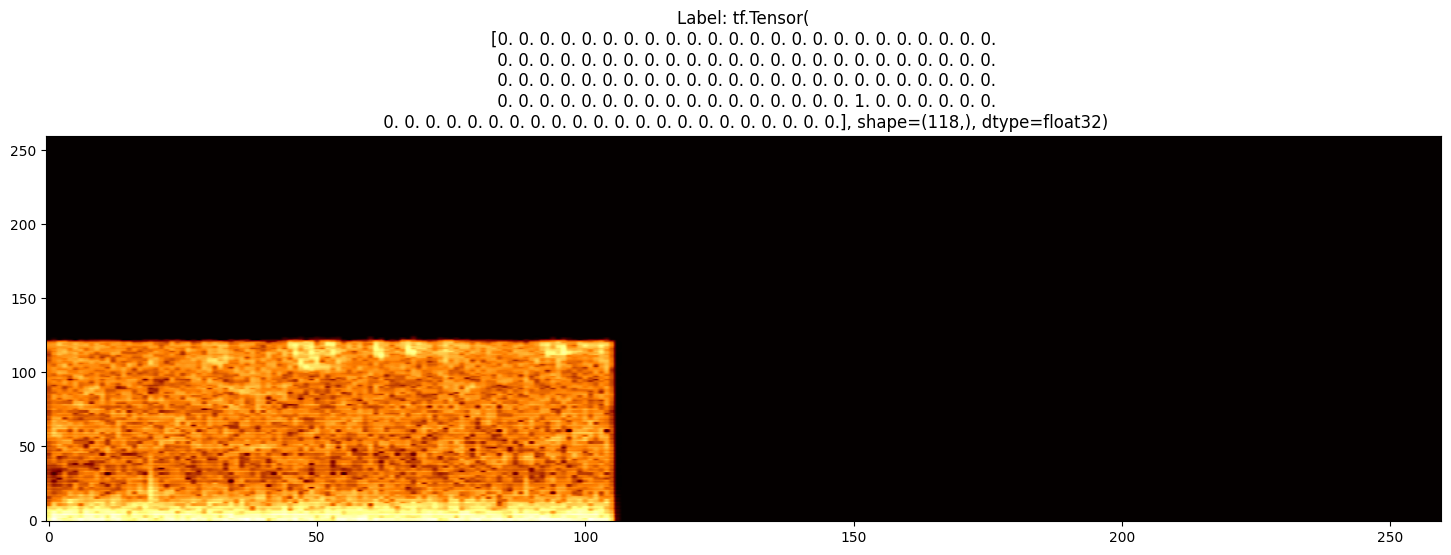

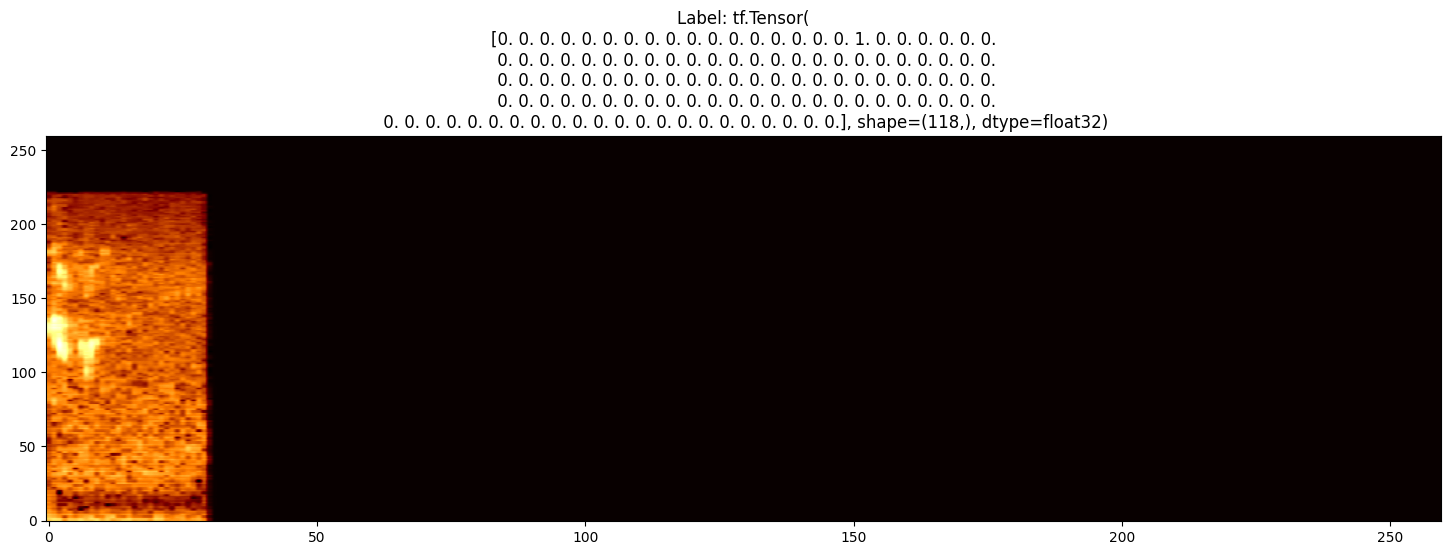

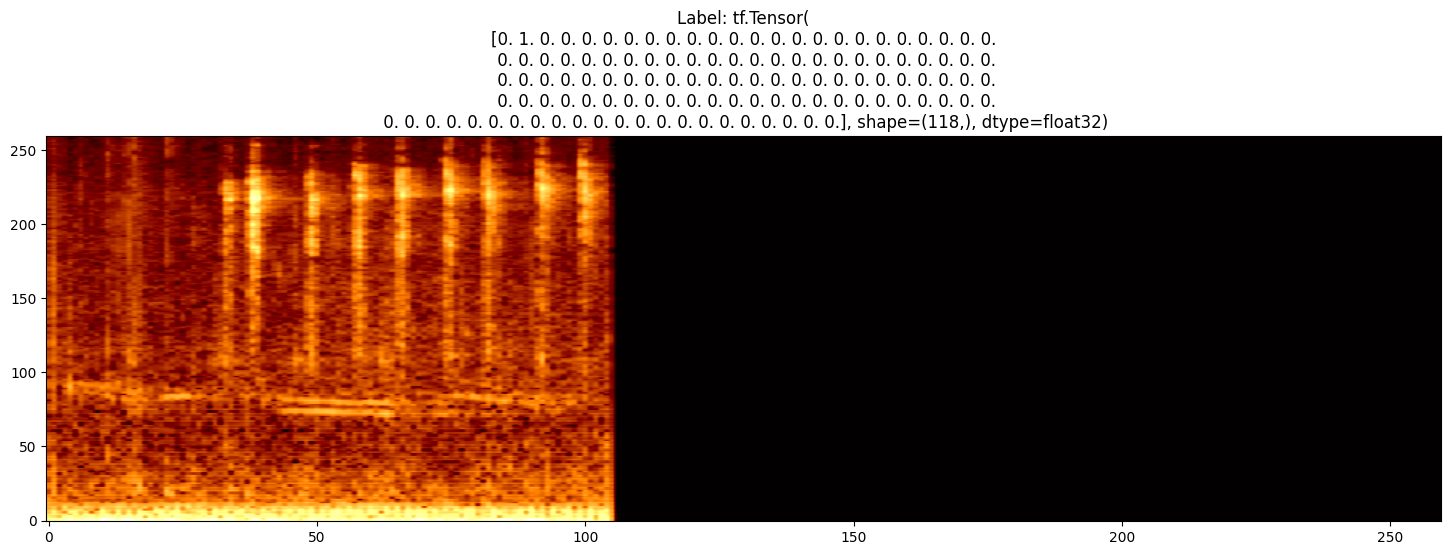

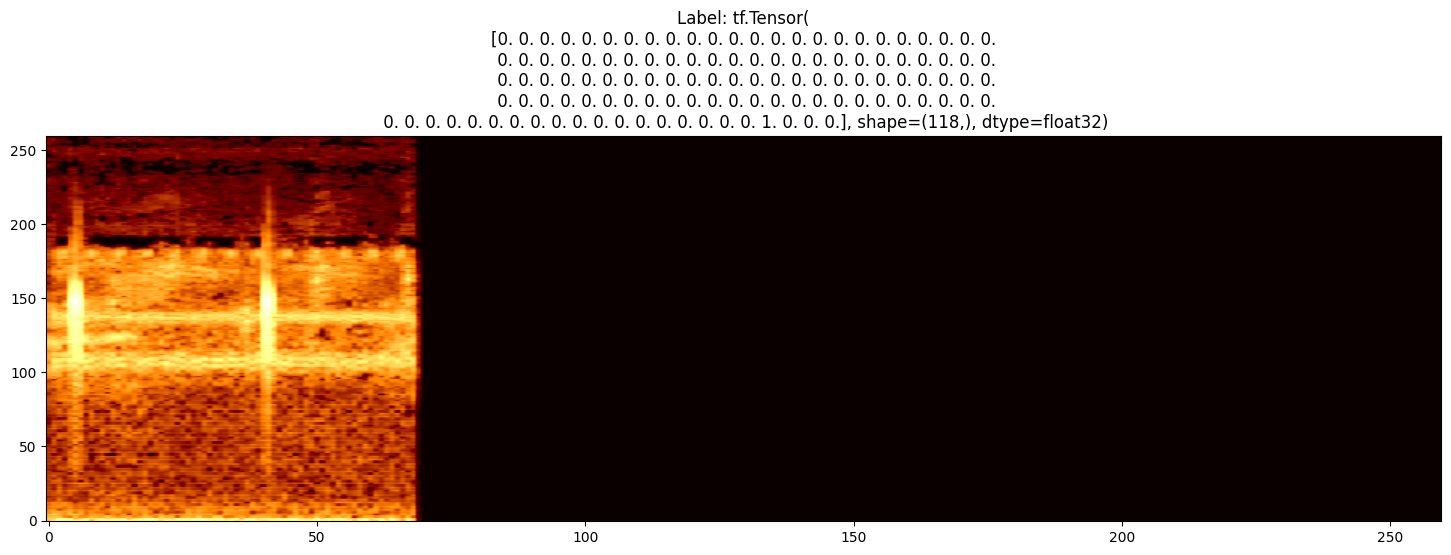

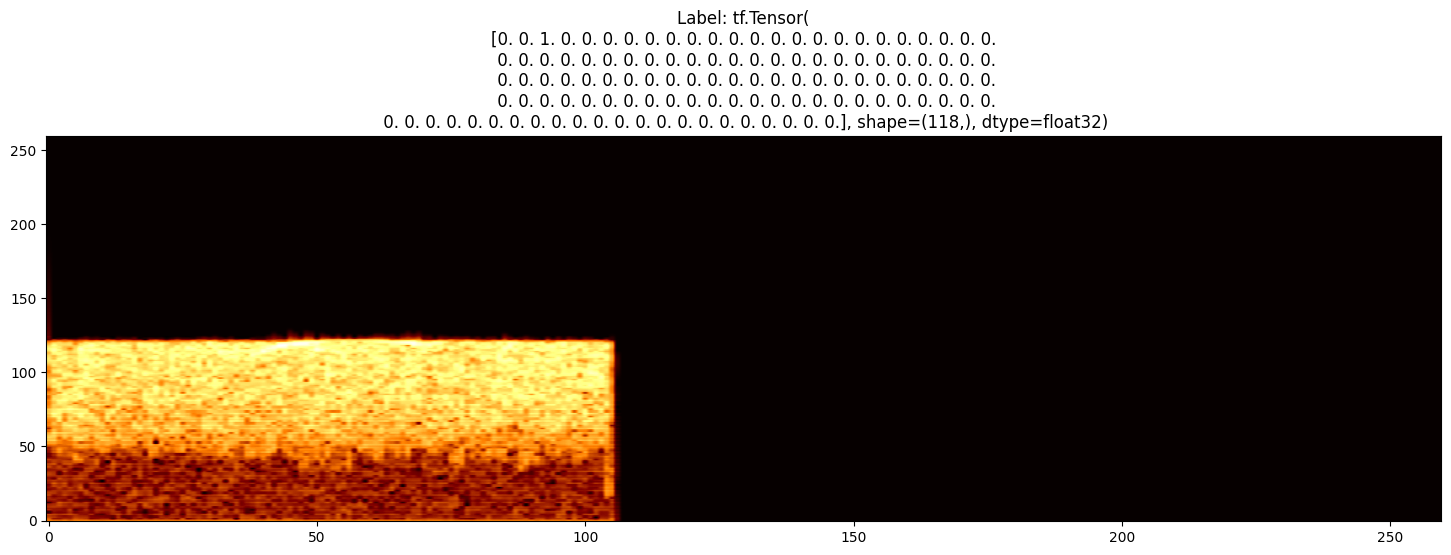

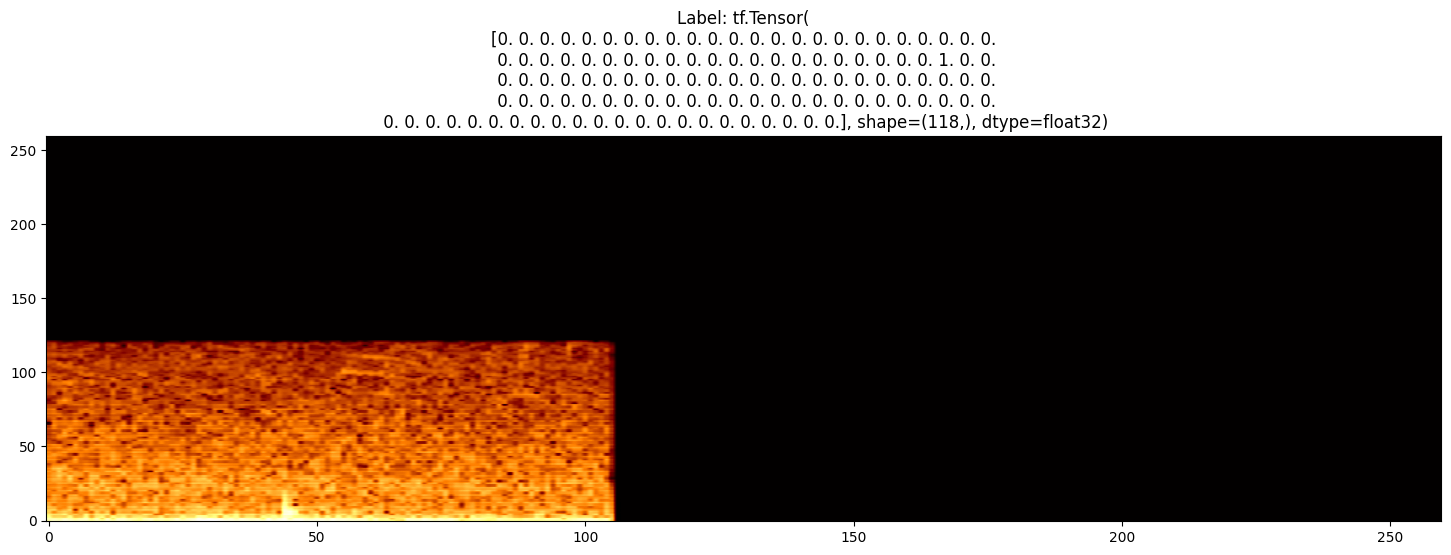

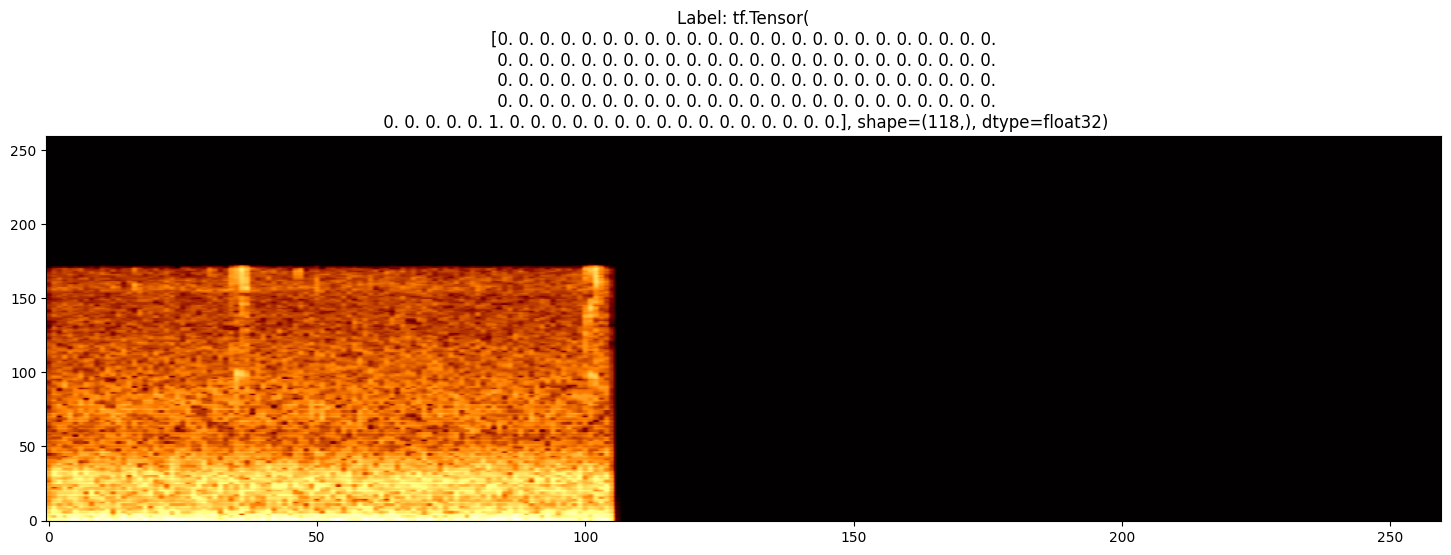

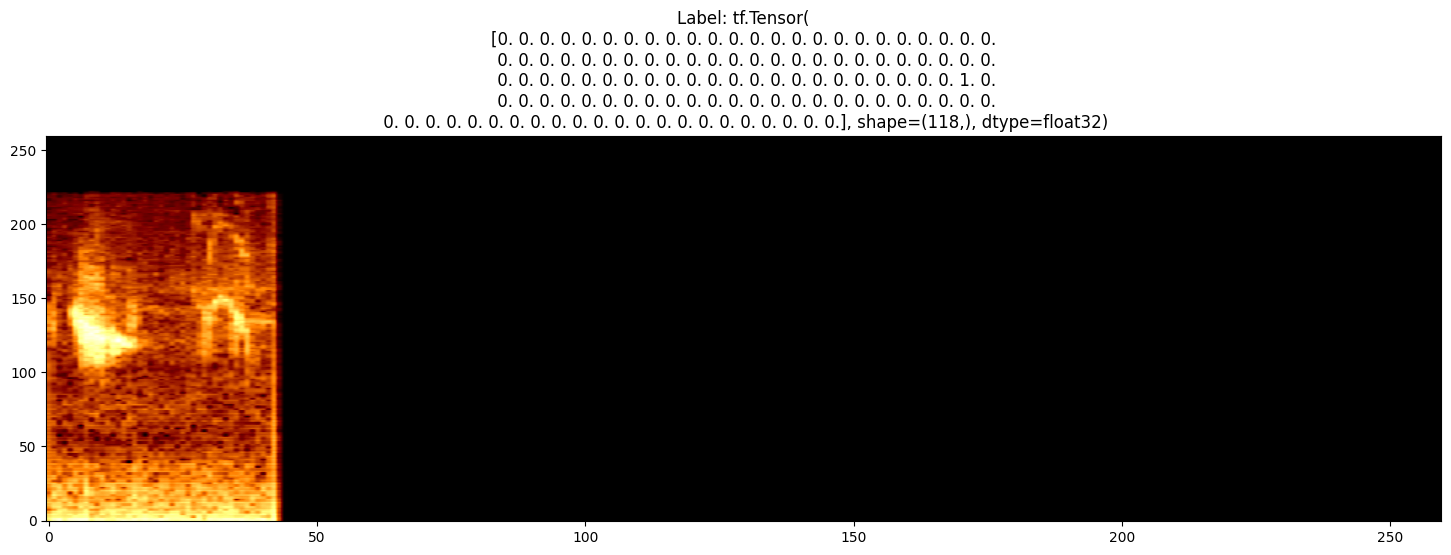

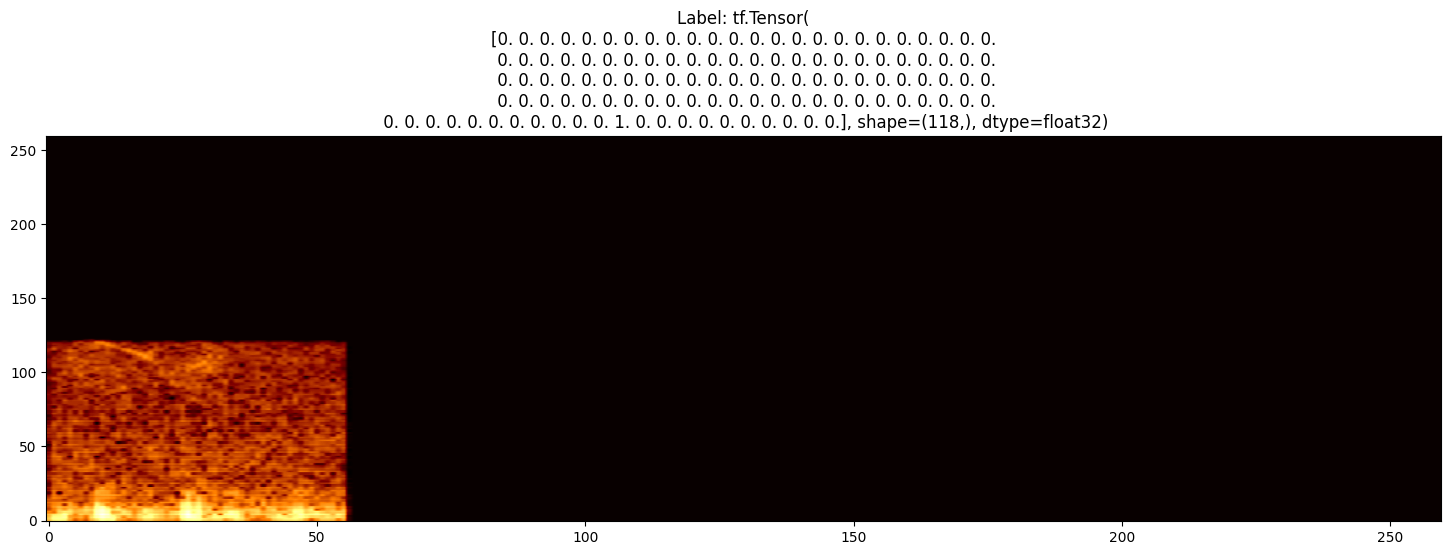

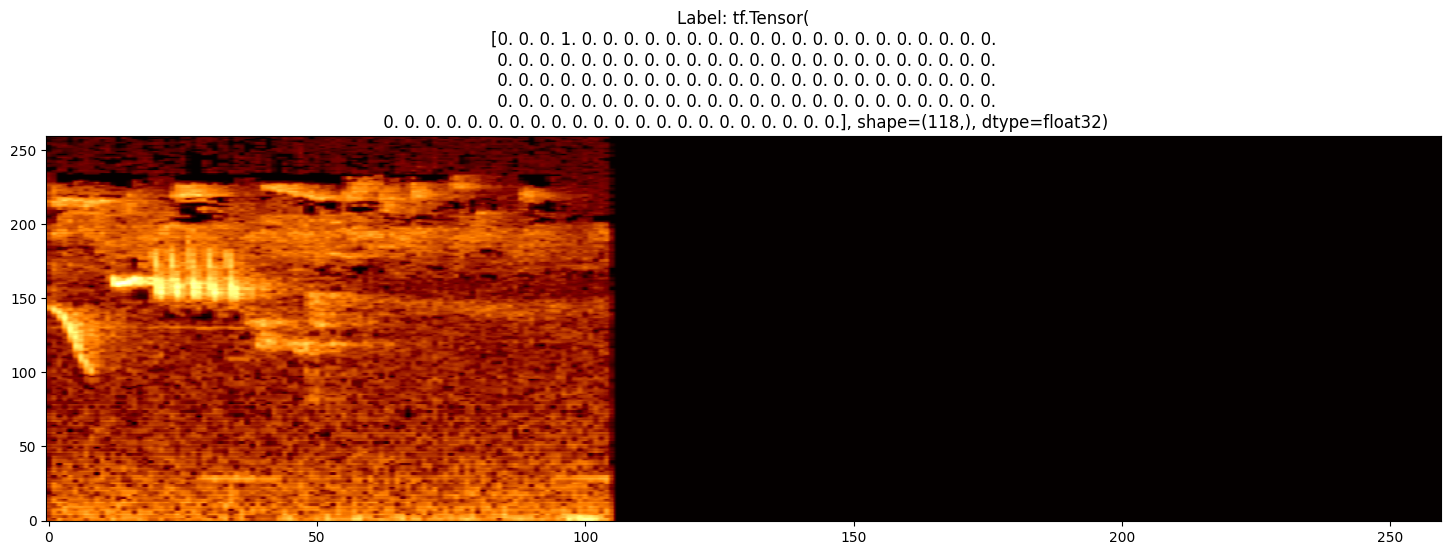

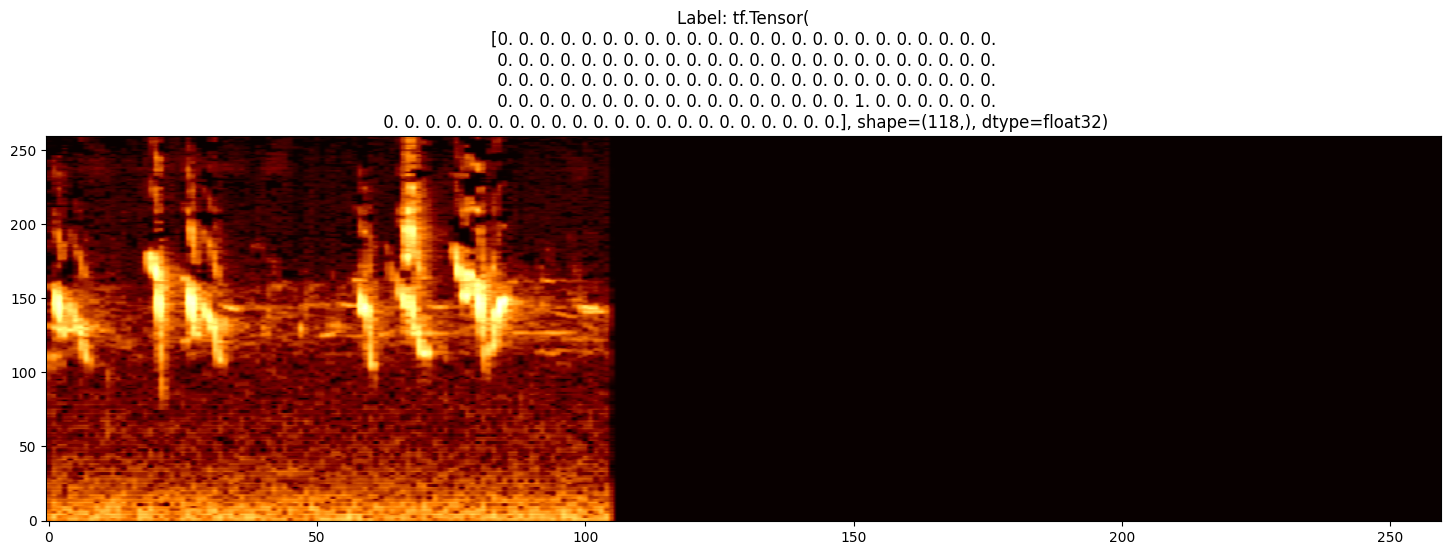

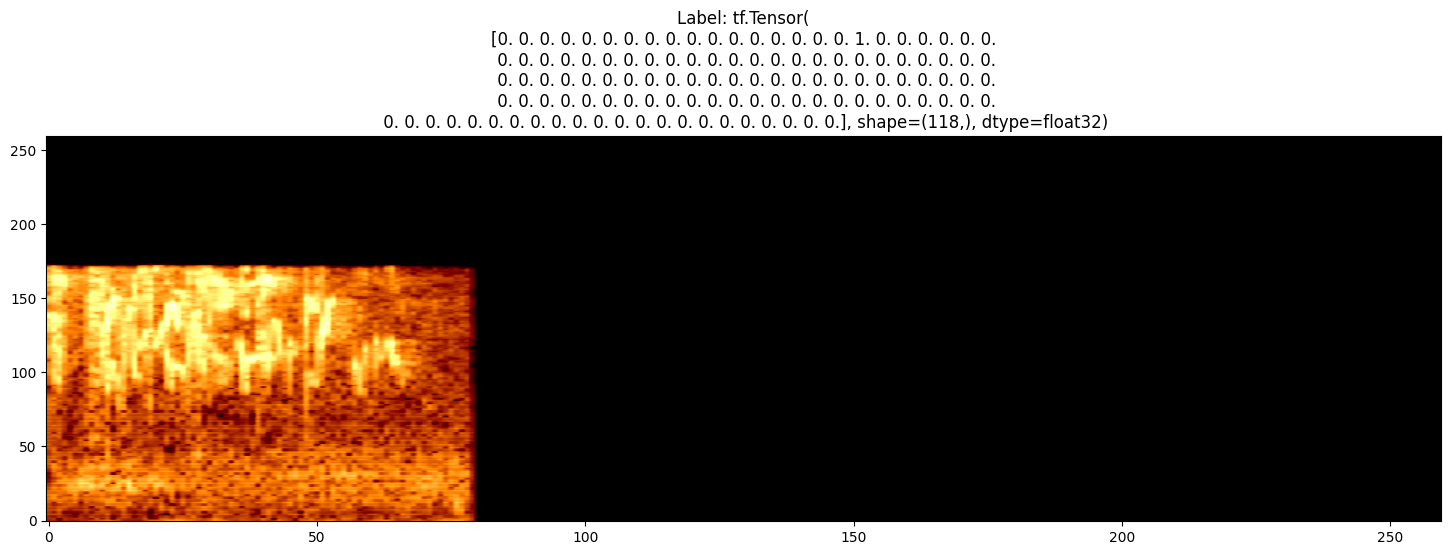

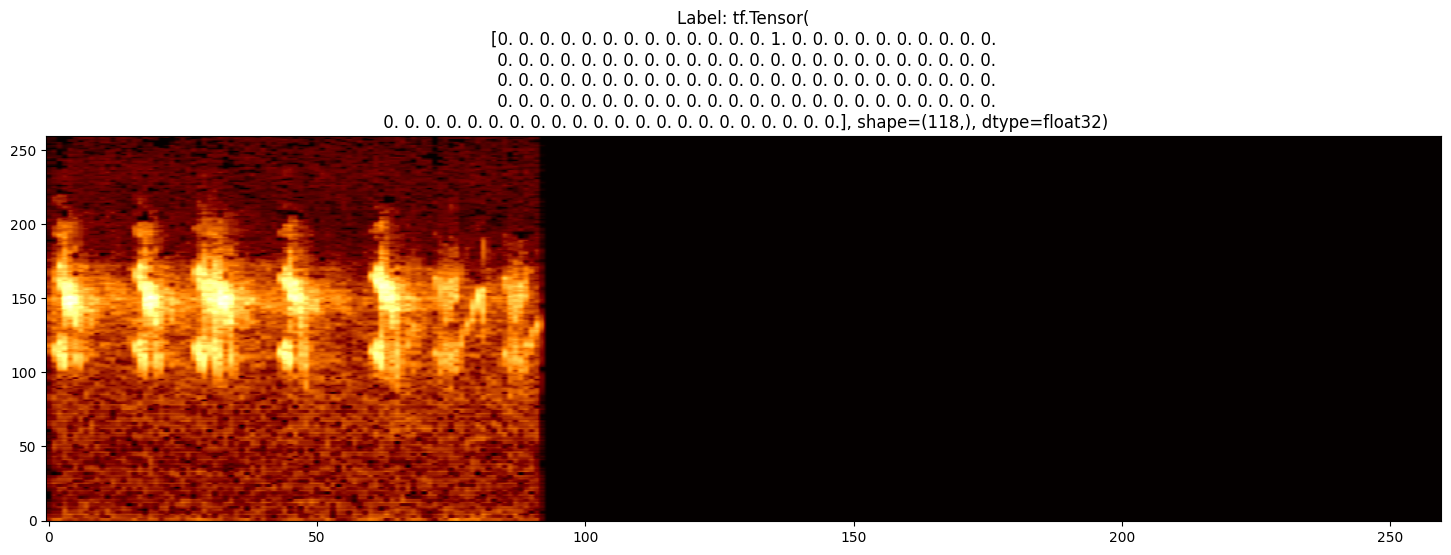

In [183]:
for melspectrogram,label in train_combined.take(1):
    print(f' sample info: {melspectrogram.shape}, \n label info: {label.shape} \n {label}')
    for example in range(melspectrogram.shape[0]):
        plt.figure(figsize=(18,5))
        plt.imshow(melspectrogram[example,:,:,0].numpy().T, cmap='afmhot', origin='lower', aspect='auto')
        plt.title('Label: ' + str(label[example,:]))
        plt.show()

We now have a dataset that have varying level of quality, all taken with the same sampling rate of 16000. The blank area above and next to the image is due to the padding applied to the melspectrograph to ensure that the input size is the same even if the data sampling rate is different. 

## Build Model for Combined Dataset

First, we need to make a directory to save the model on local device

In [175]:
# only run the code below if want to save the model
if not os.path.exists('C:/Users/regin/Documents/SIT374/models/new_models/Combined'):
    os.mkdir('C:/Users/regin/Documents/SIT374/models/new_models/Combined') 

In [ ]:
# Custom layer to wrap hub.KerasLayer
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, hub_url, trainable=True):
        super(HubLayer, self).__init__()
        self.hub_layer = hub.KerasLayer(hub_url, trainable=trainable)

    def call(self, inputs):
        return self.hub_layer(inputs)

def build_model(trainable):
    # Build a classification model using a pre-trained EfficientNetV2
    model = tf.keras.Sequential(
        [
            # Input layer with specified image dimensions
            tf.keras.layers.InputLayer(input_shape=(SCM['MODEL_INPUT_IMAGE_HEIGHT'], 
                                                    SCM['MODEL_INPUT_IMAGE_WIDTH'], 
                                                    SCM['MODEL_INPUT_IMAGE_CHANNELS'])),

            # Use the EfficientNetV2 model as a feature generator (needs 260x260x3 images)
            HubLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", trainable),

            # Add the classification layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),

            # Fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(dpp.class_names) * 8,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Another fully connected layer with multiple of the number of classes
            tf.keras.layers.Dense(len(dpp.class_names) * 4,
                                  activation="relu"),
            tf.keras.layers.BatchNormalization(),

            # Add dropout to reduce overfitting
            tf.keras.layers.Dropout(0.50),

            # Output layer with one node per class, without activation
            tf.keras.layers.Dense(len(dpp.class_names), activation=None),
        ]
    )
    # Set the input shape for the model
    model.build([None, 
                 SCM['MODEL_INPUT_IMAGE_HEIGHT'],
                 SCM['MODEL_INPUT_IMAGE_WIDTH'], 
                 SCM['MODEL_INPUT_IMAGE_CHANNELS']])

    # Display the model summary
    model.summary()

    return model

In [185]:
# allow all the weights to be trained
model_combined = build_model(True)


# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model_combined.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.75,
                                                      patience=8, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-7)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=16,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model.keras', 
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')


# fit the model to the training set
# this may take 12-24 hours to run to full model convergence depending on your machine
history_combined = model_combined.fit(train_combined, 
                            validation_data=val_combined,
                            callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
                            epochs=SCM['MAX_EPOCHS'])      

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hub_layer_6 (HubLayer)          │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 944)            │     1,209,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 944)            │         3,776 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 472)            │       446,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 472)            │         1,888 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 472)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 118)            │        55,814 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,721,902 (6.57 MB)

 Trainable params: 1,716,510 (6.55 MB)

 Non-trainable params: 5,392 (21.06 KB)

Epoch 1/30
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 804s 605ms/step - accuracy: 0.2088 - loss: 4.2257 - val_accuracy: 0.5728 - val_loss: 1.8309 - learning_rate: 1.0000e-04
Epoch 2/30
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 773s 588ms/step - accuracy: 0.4653 - loss: 2.3493 - val_accuracy: 0.6630 - val_loss: 1.3544 - learning_rate: 1.0000e-04
Epoch 3/30
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 767s 583ms/step - accuracy: 0.5493 - loss: 1.8861 - val_accuracy: 0.7232 - val_loss: 1.0812 - learning_rate: 1.0000e-04
Epoch 4/30
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 772s 587ms/step - accuracy: 0.6089 - loss: 1.5943 - val_accuracy: 0.7603 - val_loss: 0.9218 - learning_rate: 1.0000e-04
Epoch 5/30
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 796s 582ms/step - accuracy: 0.6459 - loss: 1.4144 - val_accuracy: 0.7929 - val_loss: 0.7951 - learning_rate: 1.0000e-04
Epoch 6/30
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 765s 582ms/step - accuracy: 0.6776 - loss: 1.2637 - val_accuracy: 0.8218 - val_loss: 0.6913 - learning_rate: 1.0000e-04
Epoch 7/30
1315/1315 ━━━━━━━

In [186]:
# Save the full model for use with tensorflow serving
model_combined.export('C:/Users/regin/Documents/SIT374/models/new_models/Combined')

INFO:tensorflow:Assets written to: C:/Users/regin/Documents/SIT374/models/new_models/Combined\assets


INFO:tensorflow:Assets written to: C:/Users/regin/Documents/SIT374/models/new_models/Combined\assets


Saved artifact at 'C:/Users/regin/Documents/SIT374/models/new_models/Combined'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name='keras_tensor_64')
Output Type:
  TensorSpec(shape=(None, 118), dtype=tf.float32, name=None)
Captures:
  2795857240560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795857241440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795857243904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795857232640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795857232464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795727358960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795727356144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795727356672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795727361072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2795727365120: TensorSpec(shape=(), dtype=tf.resource, 

(0.0, 1.0)

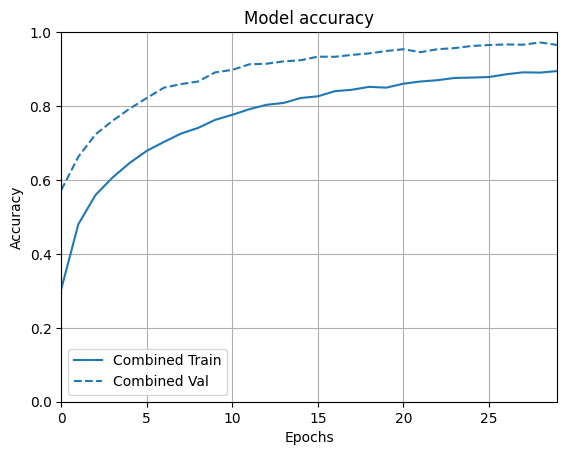

In [190]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Combined": history_combined}, metric = "accuracy")
plt.title("Model accuracy")
plt.ylim([0,1])



(0.0, 1.0)

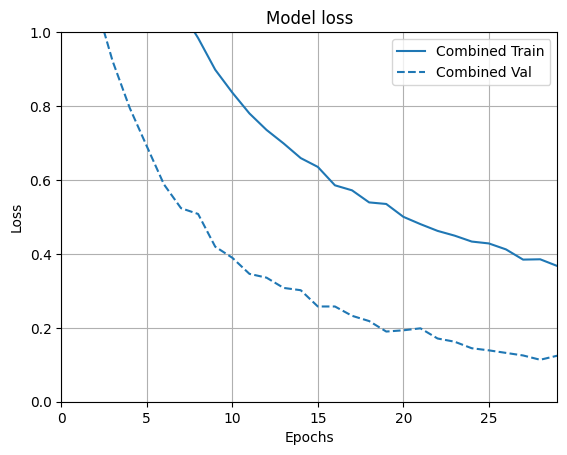

In [191]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Combined": history_combined}, metric = "loss")
plt.title("Model loss")
plt.ylim([0,1])

In [188]:
# Initialize variables to track metrics
true_labels_all_combined = []
predicted_labels_all_combined = []
class_incorrect_combined = defaultdict(int)
class_correct_combined = defaultdict(int)  # Correct predictions per class
class_total_combined = defaultdict(int)  # Total predictions per class


# run predictions
for features, labels in test_combined:
    predictions_dict = model_combined(features, training=False)
    predictions = model_combined.predict(features, verbose=0)

    for batch_idx in range(predictions.shape[0]):
        # Get the true and predicted classes
        true_class = tf.argmax(labels[batch_idx]).numpy()
        predicted_class = int(tf.argmax(predictions[batch_idx]).numpy())

        true_labels_all_combined.append(true_class)
        predicted_labels_all_combined.append(predicted_class)

        # Update per-class metrics
        class_total_combined[true_class] += 1
        if true_class == predicted_class:
            class_correct_combined[true_class] += 1
        else:
            class_incorrect_combined[true_class] += 1

# Calculate overall accuracy
overall_accuracy_combined = accuracy_score(true_labels_all_combined, predicted_labels_all_combined)
print(f"Overall Accuracy: {overall_accuracy_combined * 100:.2f}%")

# Print metrics per class
print("\nPrediction Results:")
for idx, class_name in enumerate(dpp.class_names):
    correct = class_correct_combined[idx]
    incorrect = class_incorrect_combined[idx]
    total = class_total_combined[idx]

    print(f"Class: {class_name}")
    print(f"  Total Predictions: {total}")
    print(f"  Correct Predictions: {correct}")
    print(f"  Incorrect Predictions: {incorrect}")
    if total > 0:
        print(f"  Accuracy: {correct / total * 100:.2f}%")
    else:
        print("  No predictions for this class")

# Confusion Matrix
conf_matrix_combined = confusion_matrix(true_labels_all_combined, predicted_labels_all_combined)



Overall Accuracy: 96.54%

Prediction Results:
Class: Acanthiza chrysorrhoa
  Total Predictions: 9
  Correct Predictions: 7
  Incorrect Predictions: 2
  Accuracy: 77.78%
Class: Acanthiza lineata
  Total Predictions: 10
  Correct Predictions: 9
  Incorrect Predictions: 1
  Accuracy: 90.00%
Class: Acanthiza nana
  Total Predictions: 46
  Correct Predictions: 46
  Incorrect Predictions: 0
  Accuracy: 100.00%
Class: Acanthiza pusilla
  Total Predictions: 97
  Correct Predictions: 95
  Incorrect Predictions: 2
  Accuracy: 97.94%
Class: Acanthiza reguloides
  Total Predictions: 66
  Correct Predictions: 59
  Incorrect Predictions: 7
  Accuracy: 89.39%
Class: Acanthiza uropygialis
  Total Predictions: 21
  Correct Predictions: 19
  Incorrect Predictions: 2
  Accuracy: 90.48%
Class: Acanthorhynchus tenuirostris
  Total Predictions: 50
  Correct Predictions: 44
  Incorrect Predictions: 6
  Accuracy: 88.00%
Class: Accipiter cirrocephalus
  Total Predictions: 36
  Correct Predictions: 34
  Incorre

The model is working well, with overall accuracy of >90% when tested against a test dataset of combined audio quality. 

As the data goes throught the same preprocessing steps as the current original deployed model, it should be able to work well with the current pipeline.


The model is available for access in the teams channel files: https://deakin365.sharepoint.com/:u:/r/sites/DataBytes2/Shared%20Documents/Project%20Echo/T3%202024/Combined.zip?csf=1&web=1&e=aG1l2P